Augment the literature data

In [26]:
# Load libraries and modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from modelval import pairptl, network, trainer, dataset, dw_gen, perform_eval
from modelval.ArbDataGen import arb_w_gen

import warnings
warnings.filterwarnings('ignore')

% matplotlib inline
% load_ext autoreload
% autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
# Load data frame
data = pd.read_csv('/src/Plasticity_Ker/data/kernel_training_data_auto.csv')
data.head()

,ptl_idx,pre_spk_num,pre_spk_freq,post_spk_num,post_spk_freq,ptl_occ,ptl_freq,dt1,dt2,dt3,dw_mean,dw_ste,train_len
0,1,1,0,1,0,60,1.0,-102.898046,0.0,0,-1.322590,0.0,60
1,1,1,0,1,0,60,1.0,-75.579896,0.0,0,2.674768,0.0,60
2,1,1,0,1,0,60,1.0,-80.871473,0.0,0,-12.696449,0.0,60
3,1,1,0,1,0,60,1.0,-67.562239,0.0,0,0.231446,0.0,60
4,1,1,0,1,0,60,1.0,-63.553410,0.0,0,-0.990216,0.0,60


In [28]:
# Generate data for STDP
data1 = data[data['ptl_idx']==1]
data1_gen, targets1 = dw_gen.STDP_dw_gen(n_neighbors=3)

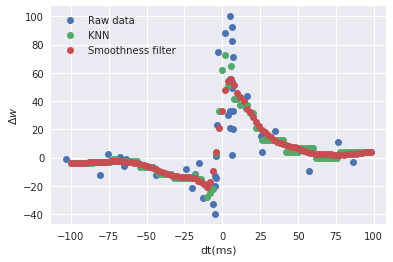

In [29]:
plt.plot(data1['dt1'], data1['dw_mean'],'o', label='Raw data')
width_list = np.concatenate([np.linspace(10,3,50), np.linspace(3,10,50)])
plt.plot(data1_gen['dt1'], targets1,'o', label='KNN')
targets1_sm = dw_gen.smooth(targets1,width_list = width_list)
plt.plot(data1_gen['dt1'],targets1_sm,'o', label='Smoothness filter')
plt.xlabel('dt(ms)')
plt.ylabel('$\Delta w$')
plt.legend(loc='upper left')

In [30]:
# Generate data for Triplet
dt = np.array([-10, -5, 0, 5, 10]).reshape(-1,1)
data2_gen, targets2 = dw_gen.triplet_dw_gen(dt)

[-110, 100, -30, 60]

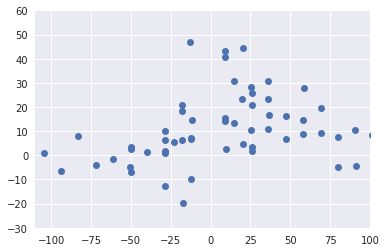

In [31]:
data3 = data[data['ptl_idx']==3]
X = np.array(data3['dt2']).reshape(-1,1)
y = np.array(data3['dw_mean']).reshape(-1,1)
plt.plot(data3['dt2'], data3['dw_mean'], 'o')
plt.axis([-110, 100, -30, 60])

In [32]:
# Generate dt1
# Insert values for Quadruplet
dt = np.concatenate([np.arange(-100,-10,2).reshape(-1,1), np.arange(10,100,2).reshape(-1,1)])
data3_gen = pd.DataFrame(data=None, columns=list(data.columns))
for i in range(len(dt)):
    new_try3 = data3.iloc[0]
    new_try3['dt2'] = dt[i]
    data3_gen = data3_gen.append(new_try3, ignore_index=True)

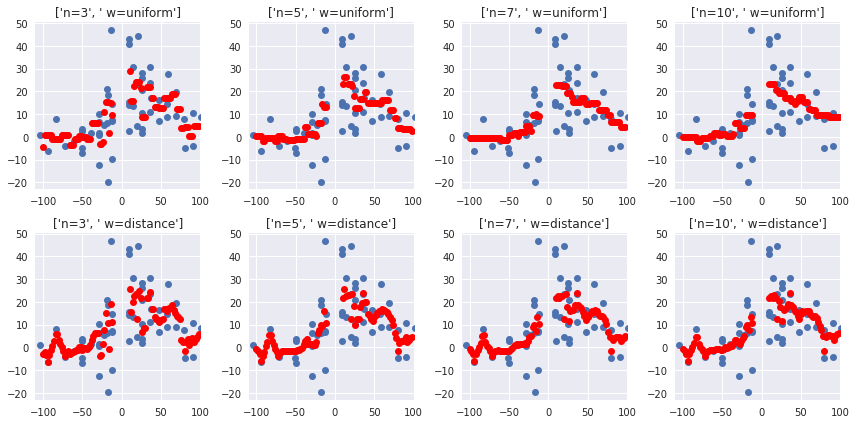

In [33]:
# Use K nearest neigbors to estimate the mean value of a given dt1
from sklearn.neighbors import KNeighborsRegressor

# Search through the parameter for the one gives the minimum reconstruction error
n_neighbors = [3,5,7,10]
weights = ['uniform', 'distance']

figure, ax = plt.subplots(2,4)
figure.set_figheight(6)
figure.set_figwidth(12)

for j in range(len(weights)):
    for i in range(len(n_neighbors)):
        
        Kn_reg = KNeighborsRegressor(n_neighbors=n_neighbors[i], weights=weights[j])
        Kn_reg.fit(X,y)
        y_pred = Kn_reg.predict(np.array(data3_gen['dt2']).reshape(-1,1))
        
        # Calculate mean squared error
        
        ax[j,i].plot(data3['dt2'], data3['dw_mean'], 'o')
        ax[j,i].plot(data3_gen['dt2'], y_pred, 'ro')
        ax[j,i].set_xlim([-110,100])
        ax[j,i].set_title(['n=%d'%(n_neighbors[i]), ' w=%s'%(weights[j])])
plt.tight_layout()

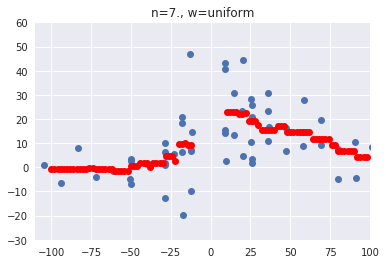

In [34]:
# Choose one parameter and generate the prediction
n_neighbors = 7
weights = 'uniform'

Kn_reg = KNeighborsRegressor(n_neighbors=n_neighbors, weights=weights)
Kn_reg.fit(X,y)
y_pred = Kn_reg.predict(np.array(data3_gen['dt2']).reshape(-1,1))
targets3=y_pred
plt.plot(data3['dt2'], data3['dw_mean'], 'o')
plt.plot(data3_gen['dt2'], y_pred, 'ro')
plt.axis([-110,100,-30,60])
plt.title('.'.join(('n=%d'%(n_neighbors), ', w=%s'%(weights))))

In [35]:
targets3.shape

(90, 1)

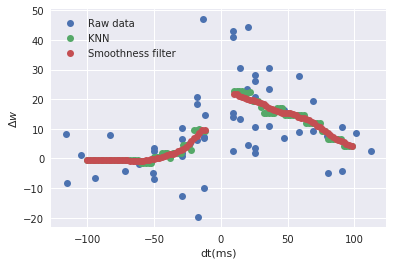

In [36]:
width_list = np.concatenate([np.linspace(10,3,45), np.linspace(3,10,45)])
targets3_sm = np.concatenate([dw_gen.smooth(targets3[:45],width_list = width_list), dw_gen.smooth(targets3[45:],width_list = width_list)])
plt.plot(data3['dt2'], data3['dw_mean'], 'o', label='Raw data')
plt.plot(data3_gen['dt2'], targets3,'o', label='KNN')
plt.plot(data3_gen['dt2'], targets3_sm,'o', label='Smoothness filter')
plt.xlabel('dt(ms)')
plt.ylabel('$\Delta w$')
plt.legend()

In [37]:
trip_para = pd.read_pickle('/src/Plasticity_Ker/data/Gerstner_trip_para_df')
trip_para
# Reorder columns to match parameter of the model
trip_para = trip_para[['A2_+', 'A3_-', 'A2_-', 'A3_+', 'Tau_+', 'Tau_x', 'Tau_-', 'Tau_y']]
trip_para

A2_+     A3_-    A2_-    A3_+ Tau_+ Tau_x Tau_-  \
Visu_AlltoAll    Full    5e-10  0.00023   0.007  0.0062  16.8   101  33.7   
                 Min         0        0  0.0071  0.0065  16.8     1  33.7   
Visu_NearestSpk  Full  8.8e-11   0.0031  0.0066   0.053  16.8   714  33.7   
                 Min         0        0   0.008    0.05  16.8     1  33.7   
Hippo_AlltoAll   Full   0.0061   0.0014  0.0016  0.0067  16.8   946  33.7   
                 Min    0.0053        0  0.0035   0.008  16.8     1  33.7   
Hippo_NearestSpk Full   0.0046  7.5e-09   0.003  0.0091  16.8   575  33.7   
                 Min    0.0046        0   0.003  0.0091  16.8     1  33.7   

                      Tau_y  
Visu_AlltoAll    Full   125  
                 Min    114  
Visu_NearestSpk  Full    40  
                 Min     40  
Hippo_AlltoAll   Full    27  
                 Min     40  
Hippo_NearestSpk Full    47  
                 Min     48

1.0 1.0


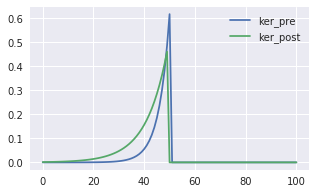

In [38]:
# Visualize kernel
from modelval.kernel import KernelGen
plt.figure(figsize=(5,3))
ker_test = KernelGen()

para = trip_para.loc[('Hippo_AlltoAll', 'Full'), :]
a = para[:4].values
tau = para[4:].values
reso_set = 2
tau_pre_post = tau[0]/reso_set  # ms
tau_post_pre = tau[2]/reso_set # ms

ker_test = KernelGen(len_kernel=101)
ker_test.trip_model_ker(para, data_name='Hippocampus')
plt.plot(ker_test.kernel_pre, label='ker_pre')
plt.plot(ker_test.kernel_post, label='ker_post')
plt.legend()
print(np.linalg.norm(ker_test.kernel_pre, ord=2), np.linalg.norm(ker_test.kernel_post, ord=2))

In [39]:
data_gen = pd.concat([data1_gen, data3_gen])
targets = np.concatenate([targets1_sm, targets3_sm])

In [40]:
data_gen['ptl_idx'].value_counts()

1.0    100
3.0     90
Name: ptl_idx, dtype: int64

([<matplotlib.lines.Line2D at 0x7f67649eb978>],)

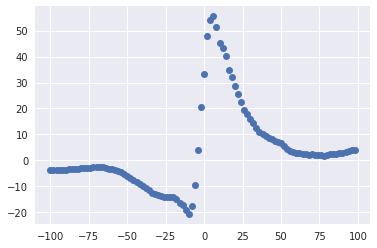

In [41]:
plt.plot(data_gen.iloc[:len(data1_gen)]['dt1'],targets[:targets1.shape[0]],'o'), 

([<matplotlib.lines.Line2D at 0x7f6764b1c550>],)

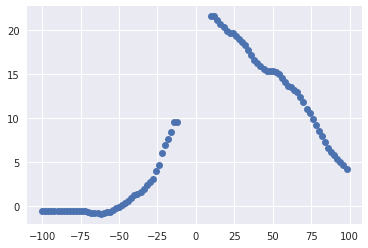

In [42]:
plt.plot(data_gen.iloc[len(data1_gen):]['dt2'],targets[targets1.shape[0]:],'o'), 

In [43]:
ptl_list = [1,3]
spk_len = int(data3_gen['train_len'].max() * 1000 / ker_test.reso_kernel)
spk_pairs, targets = arb_w_gen(df=data_gen, ptl_list=ptl_list, targets=targets, spk_len=spk_len, kernel=ker_test, net_type='triplet', aug_times=[20,20])

In [44]:
# # np.save('/src/Plasticity_Ker/data/spk_pairs.npy', spk_pairs)
# # np.save('/src/Plasticity_Ker/data/targets.npy', targets)
# spk_pairs = np.load('/src/Plasticity_Ker/data/spk_pairs.npy')
# targets = np.load('/src/Plasticity_Ker/data/targets.npy')

In [45]:
targets.shape

(3800, 1)

In [46]:
# Create the network
ground_truth_init = 0
toy_data_net = network.TripNet(kernel=ker_test, ground_truth_init=ground_truth_init, n_input=spk_pairs.shape[1])

In [47]:
# Create the trainer
save_dir= '/src/Plasticity_Ker/model/Trip_ptl1_3_real_aug2'
toy_net_trainer = trainer.Trainer(toy_data_net.loss, toy_data_net.loss, input_name=toy_data_net.inputs, target_name=toy_data_net.target, save_dir=save_dir, optimizer_config={'learning_rate': toy_data_net.lr})

In [48]:
# Obtain the training and validation data
from sklearn.model_selection import train_test_split

X_train_val, X_test, y_train_val, y_test = train_test_split(spk_pairs, targets, test_size=0.1)
X_train, X_vali, y_train, y_vali = train_test_split(X_train_val,  y_train_val, test_size=0.1)
train_data = dataset.Dataset(X_train, y_train)
vali_data = dataset.Dataset(X_vali, y_vali)

[-0.22614121 -0.27994752  0.95375919] 0.0


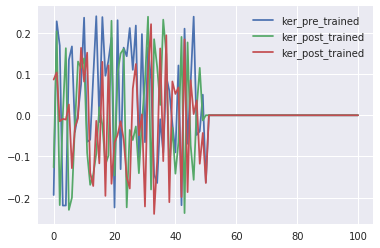

In [49]:
w_pre = toy_net_trainer.evaluate(ops=toy_data_net.kernel_pre)
w_post = toy_net_trainer.evaluate(ops=toy_data_net.kernel_post)
w_post_post = toy_net_trainer.evaluate(ops=toy_data_net.kernel_post_post)
fc_w = toy_net_trainer.evaluate(ops=toy_data_net.fc_w)
bias = toy_net_trainer.evaluate(ops=toy_data_net.bias)
plt.plot(w_pre,  label='ker_pre_trained')
plt.plot(w_post,  label='ker_post_trained')
plt.plot(w_post_post,  label='ker_post_trained')
plt.legend()
print(fc_w, bias)

In [50]:
# Learn the kernel from random initialization
learning_rate = 0.001
iterations = 5
min_error = -1
for i in range(iterations):
    toy_net_trainer.train(train_data, vali_data, batch_size=128, min_error=min_error, feed_dict={toy_data_net.lr: learning_rate})
    learning_rate = learning_rate/3


Initial validation cost=228.63789
Global Step 0150 and Step 0150: validation cost=163.38800
Updated min validation loss!Saving model...
Global Step 0200 and Step 0200: validation cost=149.33965
Updated min validation loss!Saving model...
Global Step 0250 and Step 0250: validation cost=134.21971
Updated min validation loss!Saving model...
Global Step 0300 and Step 0300: validation cost=118.12357
Updated min validation loss!Saving model...
Global Step 0350 and Step 0350: validation cost=101.18739
Updated min validation loss!Saving model...
Global Step 0400 and Step 0400: validation cost=83.72504
Updated min validation loss!Saving model...
Global Step 0450 and Step 0450: validation cost=67.48197
Updated min validation loss!Saving model...
Global Step 0500 and Step 0500: validation cost=53.37825
Updated min validation loss!Saving model...
Global Step 0550 and Step 0550: validation cost=42.62593
Updated min validation loss!Saving model...


KeyboardInterrupt: 

In [29]:
toy_net_trainer.restore_best()
w_pre = toy_net_trainer.evaluate(ops=toy_data_net.kernel_pre)
w_post = toy_net_trainer.evaluate(ops=toy_data_net.kernel_post)
w_post_post = toy_net_trainer.evaluate(ops=toy_data_net.kernel_post_post)
fc_w = toy_net_trainer.evaluate(ops=toy_data_net.fc_w)
bias = toy_net_trainer.evaluate(ops=toy_data_net.bias)
plt.plot(-1*w_pre, label='ker_pre_trained')
plt.plot(-1*w_post, label='ker_post_trained')
plt.plot(w_post_post, label='ker_post_post_trained')
plt.legend()
print([fc_w, bias])

InvalidArgumentError: Unsuccessful TensorSliceReader constructor: Failed to get matching files on /src/Plasticity_Ker/model/Trip_ptl1_3_real_aug2/best: Not found: /src/Plasticity_Ker/model/Trip_ptl1_3_real_aug2
	 [[Node: save_1/RestoreV2_1 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save_1/Const_0, save_1/RestoreV2_1/tensor_names, save_1/RestoreV2_1/shape_and_slices)]]
	 [[Node: save_1/RestoreV2_7/_23 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/gpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=1, tensor_name="edge_70_save_1/RestoreV2_7", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]

Caused by op 'save_1/RestoreV2_1', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python3.5/dist-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-25-027b16588c65>", line 3, in <module>
    toy_net_trainer = trainer.Trainer(toy_data_net.loss, toy_data_net.loss, input_name=toy_data_net.inputs, target_name=toy_data_net.target, save_dir=save_dir, optimizer_config={'learning_rate': toy_data_net.lr})
  File "/src/Plasticity_Ker/PlasticityKer/modelval/trainer.py", line 23, in __init__
    self.build()
  File "/src/Plasticity_Ker/PlasticityKer/modelval/trainer.py", line 40, in build
    self.saver_best = tf.train.Saver(variable_to_load, max_to_keep=1)      # Save only the variable
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/training/saver.py", line 1040, in __init__
    self.build()
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/training/saver.py", line 1070, in build
    restore_sequentially=self._restore_sequentially)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/training/saver.py", line 675, in build
    restore_sequentially, reshape)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/training/saver.py", line 402, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/training/saver.py", line 242, in restore_op
    [spec.tensor.dtype])[0])
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gen_io_ops.py", line 668, in restore_v2
    dtypes=dtypes, name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 2327, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 1226, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Unsuccessful TensorSliceReader constructor: Failed to get matching files on /src/Plasticity_Ker/model/Trip_ptl1_3_real_aug2/best: Not found: /src/Plasticity_Ker/model/Trip_ptl1_3_real_aug2
	 [[Node: save_1/RestoreV2_1 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save_1/Const_0, save_1/RestoreV2_1/tensor_names, save_1/RestoreV2_1/shape_and_slices)]]
	 [[Node: save_1/RestoreV2_7/_23 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/gpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=1, tensor_name="edge_70_save_1/RestoreV2_7", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]


Compare the target and prediction

In [27]:
ker_test.kernel_pre = w_pre
ker_test.kernel_post = w_post
ker_test.kernel_post_post= w_post_post
ker_test.kernel_scale = fc_w

In [28]:
spk_len = int(data1_gen['train_len'].max() * 1000 / ker_test.reso_kernel)
spk_pairs, predictions = arb_w_gen(spk_pairs=spk_pairs, spk_len=spk_len, kernel=ker_test, net_type='triplet')

In [29]:
# np.save('/src/Plasticity_Ker/data/predictions.npy', predictions)
# predictions = np.load('/src/Plasticity_Ker/data/predictions.npy')

In [30]:
x_fit = np.linspace(np.min(targets)-1, np.max(targets)+1, 100)
targets_stdp = targets[:len(data1_gen)*20]
predictions_stdp = predictions[:len(data1_gen)*20]
targets_quad = targets[len(data1_gen)*20:]
predictions_quad = predictions[len(data1_gen)*20:]
R2, corr, y_fit = perform_eval.R2_corr(predictions,targets, x_fit)
R2_stdp, corr_stdp, y_fit_stdp = perform_eval.R2_corr(predictions_stdp,targets_stdp, x_fit)
R2_quad, corr_quad, y_fit_quad = perform_eval.R2_corr(predictions_quad ,targets_quad, x_fit)

In [31]:
len(targets)

3800

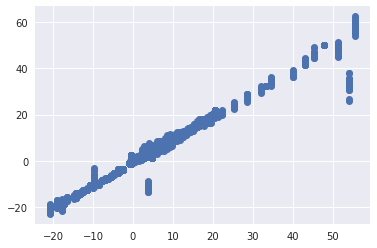

In [32]:
plt.plot(targets,predictions,'o')

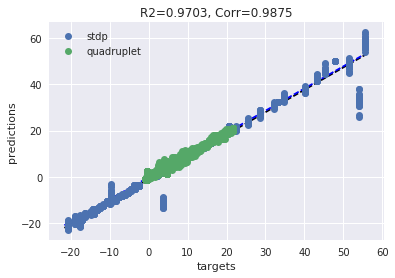

In [33]:
plt.plot(x_fit, y_fit_stdp, 'k--')
plt.plot(x_fit, y_fit_quad, 'b--')

plt.plot(targets_stdp, predictions_stdp, 'o', label='stdp')
plt.plot(targets_quad, predictions_quad, 'o', label='quadruplet')

plt.xlabel('targets')
plt.ylabel('predictions')
plt.title(''.join(('R2=%.4f'%(R2), ', Corr=%.4f'%(corr))))
plt.legend()

In [34]:
test= spk_pairs[len(data1_gen)*20:, :,:]

In [35]:
test.shape[0]

1800

In [36]:
dt2=[]
for i in range(test.shape[0]):
    test_pre = np.where(test[i][:,0]==1)[0]
    test_post = np.where(test[i][:, 1]==1)[0]
    if test_pre[0] < test_post[0]:   # Pre-post-post-pre
        idx = np.arange(0,len(test_post),2)
        test_post_1 = test_post[idx]
        test_post_2 = test_post[idx+1]
        dt2.append(np.mean(test_post_1-test_post_2))
    else:   # Post-pre-pre-post
        idx = np.arange(0,len(test_pre),2)
        test_pre_1 = test_pre[idx]
        test_pre_2 = test_pre[idx+1]
        dt2.append(np.mean(test_pre_2-test_pre_1))

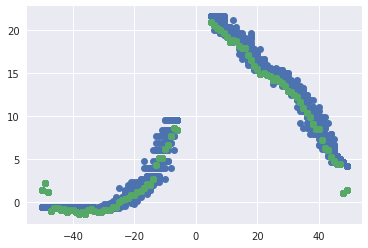

In [37]:
plt.plot(dt2, targets_quad, 'o')
plt.plot(dt2, predictions_quad, 'o')

Generate test restuls

In [38]:
ptl_list = [1]
spk_len = int(data1_gen['train_len'].max() * 1000 / ker_test.reso_kernel)
spk_pairs, predictions = arb_w_gen(spk_pairs=X_test, df=data1_gen, ptl_list=ptl_list, spk_len=spk_len, kernel=ker_test, aug_times=[20])

In [39]:
targets = y_test

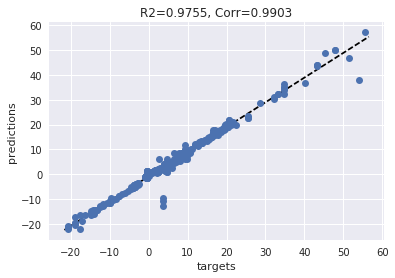

In [43]:
# Calculate R square
R2 = 1 - np.sum(np.square(predictions - targets))/np.sum(np.square(targets - np.mean(targets)))
# Calculate correlation coefficient
corr = np.sum(np.dot((predictions - np.mean(predictions)).T, targets - np.mean(targets)))/np.std(predictions)/np.std(targets)/len(targets)
b1 = np.sum(np.dot((predictions - np.mean(predictions)).T, targets - np.mean(targets)))/np.sum(np.square(targets - np.mean(targets)))
b2 = np.mean(predictions) - np.mean(targets)*b1
x_fit = np.linspace(np.min(targets)-1, np.max(targets)+1, 100)
y_fit = x_fit * b1 + b2
plt.plot(x_fit, y_fit, 'k--')
plt.plot(targets, predictions, 'ro')
plt.xlabel('targets')
plt.ylabel('predictions')
plt.title(''.join(('R2=%.4f'%(R2), ', Corr=%.4f'%(corr))))